In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install hmmlearn

In [2]:
import numpy as np
import pandas as pd
import os
import zipfile
from hmmlearn import hmm
import joblib
import matplotlib.pyplot as plt
import cupy as cp
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# Define zip file paths for Focal and NonFocal
zip_files_and_paths = [
    {
        "category": "Focal",
        "zip_files": [
            "/content/drive/My Drive/Colab Notebooks/Focal_zip/Data_F_Ind_1_750.zip",
            "/content/drive/My Drive/Colab Notebooks/Focal_zip/Data_F_Ind_751_1500.zip",
            "/content/drive/My Drive/Colab Notebooks/Focal_zip/Data_F_Ind_1501_2250.zip",
            "/content/drive/My Drive/Colab Notebooks/Focal_zip/Data_F_Ind_2251_3000.zip",
            "/content/drive/My Drive/Colab Notebooks/Focal_zip/Data_F_Ind_3001_3750.zip"
        ],
        "extract_path": "/content/drive/My Drive/Colab Notebooks/Focal"
    },
    {
        "category": "NonFocal",
        "zip_files": [
            "/content/drive/My Drive/Colab Notebooks/Nonfocal_zip/Data_N_Ind_1_750.zip",
            "/content/drive/My Drive/Colab Notebooks/Nonfocal_zip/Data_N_Ind_751_1500.zip",
            "/content/drive/My Drive/Colab Notebooks/Nonfocal_zip/Data_N_Ind_1501_2250.zip",
            "/content/drive/My Drive/Colab Notebooks/Nonfocal_zip/Data_N_Ind_2251_3000.zip",
            "/content/drive/My Drive/Colab Notebooks/Nonfocal_zip/Data_N_Ind_3001_3750.zip"
        ],
        "extract_path": "/content/drive/My Drive/Colab Notebooks/NonFocal"
    }
]

# Loop through each category and process its zip files
for category_info in zip_files_and_paths:
    category = category_info["category"]
    zip_files = category_info["zip_files"]
    extract_path = category_info["extract_path"]

    # Ensure the target extraction directory exists
    os.makedirs(extract_path, exist_ok=True)

    # Process each zip file
    for zip_path in zip_files:
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            print(f"Extracted {zip_path} to {extract_path}")
        except Exception as e:
            print(f"Failed to extract {zip_path}: {e}")


In [3]:
# Define folder paths and file patterns
folders = {
    "Focal": {
        "folder_path": "/content/drive/My Drive/Colab Notebooks/Focal",
        "file_pattern": "Data_F_Ind"
          # "file_pattern": "Data_F_Ind0001"
    },
    "NonFocal": {
        "folder_path": "/content/drive/My Drive/Colab Notebooks/NonFocal",
        "file_pattern": "Data_N_Ind"
        #  "file_pattern": "Data_N_Ind0001"
    }
}

# Initialize empty dataframes for Focal and NonFocal
focal_data = []
nonfocal_data = []

# Process files and append data to the respective lists
for label, info in folders.items():
    folder_path = info["folder_path"]
    file_pattern = info["file_pattern"]

    for txt_file in sorted(os.listdir(folder_path)):
        if txt_file.startswith(file_pattern) and txt_file.endswith(".txt"):  # Match pattern
            file_path = os.path.join(folder_path, txt_file)

            # Read the file content
            with open(file_path, 'r') as file:
                file_content = file.read()

                # Append to the respective list
                if label == "Focal":
                    focal_data.append({"FileName": txt_file, "Content": file_content})
                elif label == "NonFocal":
                    nonfocal_data.append({"FileName": txt_file, "Content": file_content})

# Convert lists to pandas dataframes
focal_df = pd.DataFrame(focal_data)
nonfocal_df = pd.DataFrame(nonfocal_data)

In [4]:
focal_df

,FileName,Content
0,Data_F_Ind0001.txt,"-23.584467, 22.621477\n -20.180197, 26...."
1,Data_F_Ind0002.txt,"1.770672, 2.166060\n 7.448948, 11...."
2,Data_F_Ind0003.txt,"-22.218569, -6.315594\n -20.903902, 2...."
3,Data_F_Ind0004.txt,"15.340358, -0.708561\n 15.932686, -9...."
4,Data_F_Ind0005.txt,"-139.301895, -32.410355\n -134.347473, -50...."
...,...,...
3745,Data_F_Ind3746.txt,"-119.777565, -4.040848\n -128.405029, -9...."
3746,Data_F_Ind3747.txt,"-40.209297, -25.315691\n -38.833210, -13...."
3747,Data_F_Ind3748.txt,"20.044878, 26.007835\n 24.044386, 23...."
3748,Data_F_Ind3749.txt,"42.665413, 28.149704\n 43.217628, 32...."


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
# Function to parse the signal data from the 'Content' column
def parse_signal(content):
    """Parse the signal content, which is a multiline string with comma-separated values."""
    lines = content.strip().split('\n')
    signal = []
    for line in lines:
        # Strip any leading/trailing spaces and split by commas
        line = line.replace(" ", "")  # Remove any extra spaces around the numbers
        signal.append(list(map(float, line.split(','))))  # Convert the string values to float
    return np.array(signal)

# Initialize an array to hold all observed data from all patients
all_observed_data = []

# Loop through the focal_df and nonfocal_df data to load and process each signal
for idx, row in focal_df.iterrows():
    content = row['Content']
    focal_signal = parse_signal(content)
    # Move to GPU
    focal_signal_tensor = torch.tensor(focal_signal, dtype=torch.float32).to(device)
    all_observed_data.append(focal_signal_tensor)

for idx, row in nonfocal_df.iterrows():
    content = row['Content']
    nonfocal_signal = parse_signal(content)
    # Move to GPU
    nonfocal_signal_tensor = torch.tensor(nonfocal_signal, dtype=torch.float32).to(device)
    all_observed_data.append(nonfocal_signal_tensor)

# Combine all the observed data (now on GPU)
combined_data = torch.cat(all_observed_data, dim=0)  # Concatenate the signals on GPU

# Reshape the data to fit the HMM (HMM expects 2D data: samples x features)
combined_data_reshaped = combined_data.reshape(-1, 1)  # Flatten the signals for HMM

# Now the combined data is on the GPU

# Define the HMM class
class HMM(torch.nn.Module):
    def __init__(self, n_components, n_features):
        super(HMM, self).__init__()
        self.n_components = n_components
        self.transition_matrix = torch.nn.Parameter(torch.rand(n_components, n_components).to(device))  # Transition matrix
        self.means = torch.nn.Parameter(torch.rand(n_components).to(device))  # Mean of Gaussian for each state
        self.stddevs = torch.nn.Parameter(torch.rand(n_components).to(device))  # Standard deviation of Gaussian for each state
        self.initial_probs = torch.nn.Parameter(torch.rand(n_components).to(device))  # Initial state probabilities
        self.transition_matrix.data = torch.nn.functional.softmax(self.transition_matrix.data, dim=1)
        self.initial_probs.data = torch.nn.functional.softmax(self.initial_probs.data, dim=0)

    def forward(self, observations):
        """ The forward pass for the HMM model. """
        n_samples = observations.size(0)
        log_probabilities = torch.zeros(n_samples, self.n_components, device=device)

        # Calculate emission probabilities for each state (Gaussian distributions)
        for state in range(self.n_components):
            mean = self.means[state]
            stddev = self.stddevs[state]
            # Gaussian likelihood
            log_probabilities[:, state] = -0.5 * torch.log(2 * torch.pi * stddev ** 2) - \
                                          (observations.squeeze() - mean) ** 2 / (2 * stddev ** 2)

        return log_probabilities

# Initialize the model
model = HMM(n_components=3, n_features=1).to(device)  # Ensure the model is on the GPU

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training setup
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass: compute log-likelihood of the observations given the model
    log_probs = model(combined_data_reshaped)  # Now it's using the data on GPU

    # Compute the negative log-likelihood (sum across all samples and states)
    log_likelihood = log_probs.sum()

    # Backpropagate and update parameters
    log_likelihood.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Log-Likelihood: {log_likelihood.item()}")

print("Model training completed.")


Epoch 10/100, Log-Likelihood: -1607841873920.0
Epoch 20/100, Log-Likelihood: -1664724369408.0
Epoch 30/100, Log-Likelihood: -1725847044096.0
Epoch 40/100, Log-Likelihood: -1792043122688.0
Epoch 50/100, Log-Likelihood: -1864204025856.0
Epoch 60/100, Log-Likelihood: -1943327604736.0
Epoch 70/100, Log-Likelihood: -2030582890496.0
Epoch 80/100, Log-Likelihood: -2127382577152.0
Epoch 90/100, Log-Likelihood: -2235475427328.0
Epoch 100/100, Log-Likelihood: -2357064105984.0
Model training completed.


In [9]:
torch.save(model.state_dict(), 'epilepsy_hmm_model_real_data.pth')

In [ ]:
### Decoding Signals with Viterbi Algorithm

# Assume model is trained and device is set to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def viterbi(observations, model):
    """
    Decodes the most likely sequence of hidden states using the Viterbi algorithm.
    The function assumes you are using a PyTorch model.
    """
    n_samples = observations.size(0)
    n_states = model.n_components

    # Initialize Viterbi variables
    log_probs = model(observations)  # Log probability for each state at each time step
    dp = torch.zeros(n_samples, n_states, device=device)
    backpointer = torch.zeros(n_samples, n_states, device=device)

    # Initialization (first time step)
    dp[0] = log_probs[0] + torch.log(model.initial_probs)

    # Recursion (for all subsequent time steps)
    for t in range(1, n_samples):
        for state in range(n_states):
            trans_probs = dp[t-1] + torch.log(model.transition_matrix[:, state])
            dp[t, state] = log_probs[t, state] + torch.max(trans_probs)
            backpointer[t, state] = torch.argmax(trans_probs)

    # Termination: find the most probable last state
    best_last_state = torch.argmax(dp[-1])

    # Backtrack to find the best path
    best_path = torch.zeros(n_samples, dtype=torch.long, device=device)
    best_path[-1] = best_last_state
    for t in range(n_samples - 2, -1, -1):
        best_path[t] = backpointer[t+1, best_path[t+1]]

    return best_path

In [ ]:
# Reshape the data to fit the HMM (HMM expects 2D data: samples x features)
combined_data_reshaped = combined_data.reshape(-1, 1)
# Convert data to torch tensor and move it to GPU if available
observed_data_tensor = torch.tensor(combined_data_reshaped, dtype=torch.float32).to(device)

In [ ]:
# Example data (replace with your actual data tensor)
observed_data = observed_data_tensor
# observed_data = torch.randn(100, 1).to(device)  # Replace with actual observation tensor
# Assuming the trained model is available
hidden_states = viterbi(observed_data, model)
print(f"Most likely hidden states: {hidden_states}")

In [ ]:
# #Load the model
# model = HMM(n_components, n_features).to(device)
# model.load_state_dict(torch.load('epilepsy_hmm_model.pth'))
# model.eval()  # Switch to evaluation mode

In [ ]:
# # Test on new data
# predicted_log_probs = model(new_data_tensor)  # Likelihood of the new data
# predicted_states = viterbi(new_data_tensor, model)  # Most likely hidden states

# print(f"Predicted log-likelihood: {predicted_log_probs.sum().item()}")
# print(f"Predicted hidden states: {predicted_states}")

Analysis

In [5]:
def process_coordinates(df):
    """
    Processes the 'Content' column of the dataframe and splits the coordinate pairs
    into 'X' and 'Y' columns.

    Args:
    - df (pd.DataFrame): Input dataframe with 'FileName' and 'Content' columns.

    Returns:
    - pd.DataFrame: DataFrame with only 'X' and 'Y' columns.
    """
    # Step 1: Split the 'Content' column by newline and explode the list into individual rows
    df['Content'] = df['Content'].str.split('\n')
    df_exploded = df.explode('Content')

    # Step 2: Split the coordinate pairs into 'X' and 'Y' columns
    df_exploded[['X', 'Y']] = df_exploded['Content'].str.split(',', expand=True)

    # Step 3: Convert 'X' and 'Y' to numeric (float), errors='coerce' to handle any invalid entries
    df_exploded[['X', 'Y']] = df_exploded[['X', 'Y']].apply(pd.to_numeric, errors='coerce')

    # Drop the 'FileName' and 'Content' columns
    df_exploded.drop(columns=['FileName', 'Content'], inplace=True)

    return df_exploded

# Process focal_df and nonfocal_df to get only X and Y columns
focal_df_cleaned = process_coordinates(focal_df)
nonfocal_df_cleaned = process_coordinates(nonfocal_df)

In [9]:
focal_df_cleaned

,X,Y
0,-23.584467,22.621477
0,-20.180197,26.547081
0,-16.631811,28.431639
0,-12.762078,30.098673
0,-10.451992,30.030939
...,...,...
0,18.566311,0.149878
0,18.048351,-3.365252
0,17.817694,-4.722577
0,17.604982,-3.035015


In [ ]:
focal_df_cleaned.dropna(inplace=True)
nonfocal_df_cleaned.dropna(inplace=True)

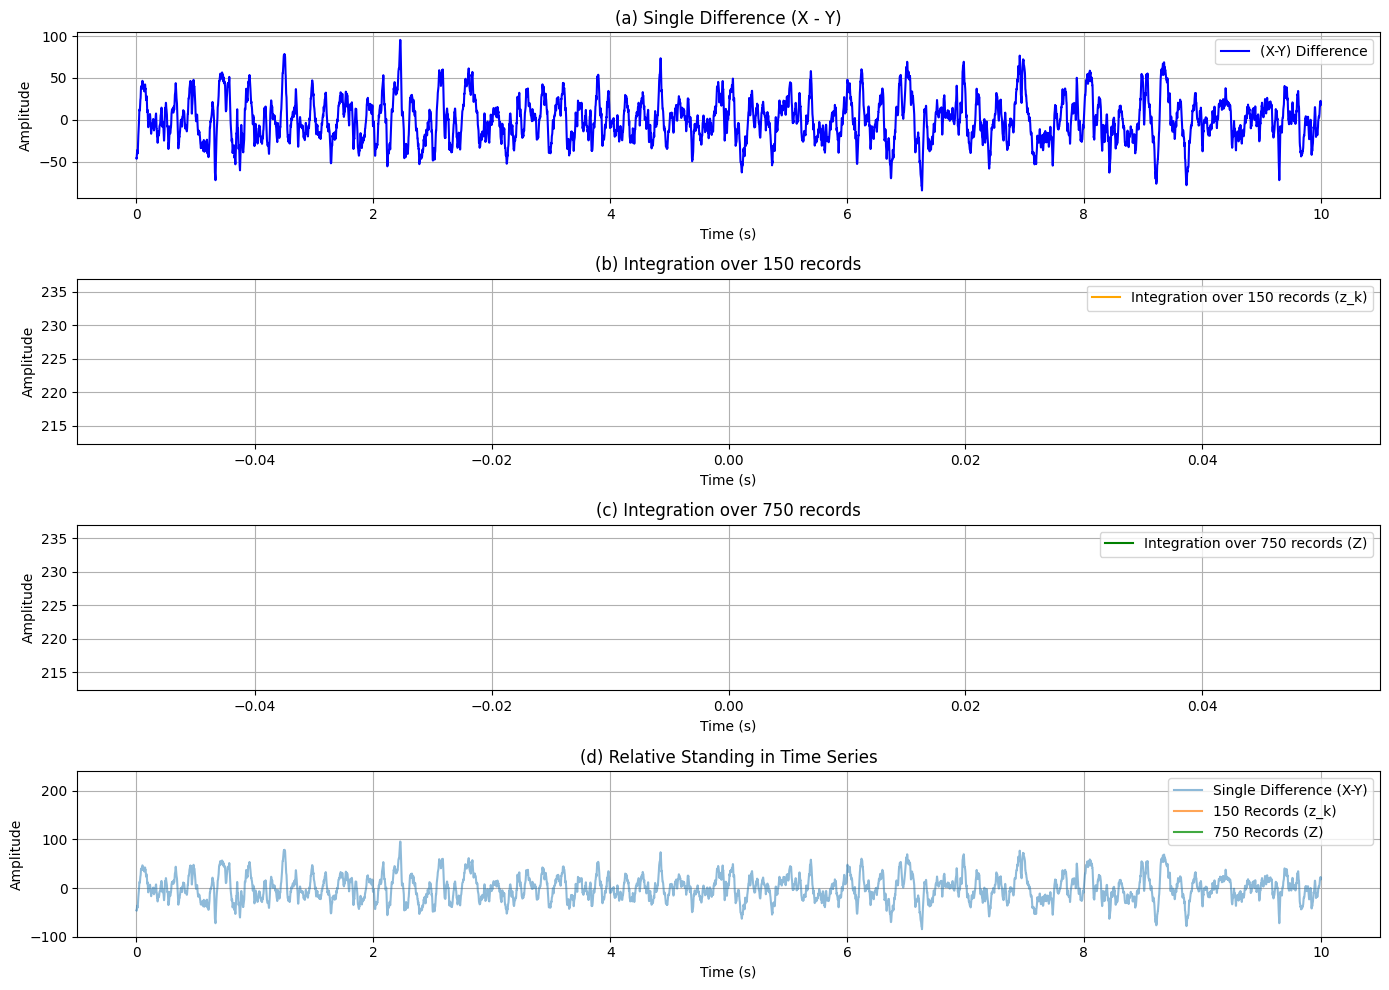

In [22]:
# Function to calculate differences between X and Y
def calculate_difference(data):
    return data['X'] - data['Y']

# Function to integrate differences over groups of records
def integrate_differences(diff_series, group_size):
    return diff_series.groupby(diff_series.index // group_size).sum()

# Ensure the dataframe is sorted by time or index (if necessary)
focal_df_cleaned = focal_df_cleaned.sort_index()

# Calculate differences (X - Y)
focal_df_cleaned['difference'] = calculate_difference(focal_df_cleaned)

# Integration over 150 records (z_k)
z_k = integrate_differences(focal_df_cleaned['difference'], group_size=150)

# Integration over 750 records (Z) - Summing over z_k
Z = integrate_differences(z_k, group_size=5)

# Generate time scales for each plot
time_scale_original = np.linspace(0, 10, len(focal_df_cleaned))  # For original (X-Y)
time_scale_zk = np.linspace(0, 10, len(z_k))  # For z_k (150 records)
time_scale_Z = np.linspace(0, 10, len(Z))  # For Z (750 records)

# Plotting
plt.figure(figsize=(14, 10))

# (a) Single difference (X - Y)
plt.subplot(4, 1, 1)
plt.plot(time_scale_original, focal_df_cleaned['difference'], label="(X-Y) Difference", color='blue')
plt.title("(a) Single Difference (X - Y)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()

# (b) Integration over 150 records (z_k)
plt.subplot(4, 1, 2)
plt.plot(time_scale_zk, z_k, label="Integration over 150 records (z_k)", color='orange')
plt.title("(b) Integration over 150 records")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()

# (c) Integration over 750 records (Z)
plt.subplot(4, 1, 3)
plt.plot(time_scale_Z, Z, label="Integration over 750 records (Z)", color='green')
plt.title("(c) Integration over 750 records")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()

# (d) Relative standing among them in time series
plt.subplot(4, 1, 4)
plt.plot(time_scale_original, focal_df_cleaned['difference'], label="Single Difference (X-Y)", alpha=0.5)
plt.plot(time_scale_zk, z_k, label="150 Records (z_k)", alpha=0.7)
plt.plot(time_scale_Z, Z, label="750 Records (Z)", alpha=0.9)
plt.title("(d) Relative Standing in Time Series")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

In [ ]:

# Define the LSTM + 1D-CNN hybrid model
class HybridModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(HybridModel, self).__init__()

        # 1D Convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # LSTM layer
        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size, batch_first=True)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Apply convolution layers
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)

        # Reshape to (batch_size, seq_len, input_size) for LSTM
        x = x.permute(0, 2, 1)

        # Apply LSTM
        lstm_out, (hn, cn) = self.lstm(x)

        # Get the last hidden state from LSTM for classification
        out = self.fc(hn[-1])
        return out

# Set parameters
input_size = 64  # Output from the last convolution layer
hidden_size = 128  # Size of LSTM hidden state
num_classes = 3  # Subclinical seizure, clinical seizure, normal

# Generate synthetic data
patients = 3
channels_per_series = 200
time_points = 5120  # 10 seconds at 512 Hz
sampling_rate = 512  # Hz

# Dummy data generation (replace with actual synthetic data generation)
data = np.random.randn(patients, channels_per_series, time_points)  # 3 patients, 200 channels, 5120 time points
labels = np.random.randint(0, num_classes, (patients, channels_per_series))  # Random labels (0, 1, 2)

# Convert data and labels to tensors
data_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Reshape the data to be in the right format for Conv1D
# Conv1D expects the shape [batch_size, channels, length], where:
#   - batch_size = patients * channels_per_series (because each channel is treated as a separate sample)
#   - channels = 1 (each sequence for each channel)
#   - length = time_points (each time series has time_points length)
data_tensor = data_tensor.view(-1, 1, time_points)  # Reshape: [patients * channels_per_series, 1, time_points]

# Create DataLoader for batching
dataset = TensorDataset(data_tensor, labels_tensor.view(-1))  # Flatten labels to match the reshaped data
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize the model
model = HybridModel(input_size=64, hidden_size=128, num_classes=num_classes)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(10):  # For 10 epochs
    model.train()
    for batch_data, batch_labels in dataloader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_data)

        # Calculate loss
        loss = criterion(outputs, batch_labels)

        # Backward pass
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

print("Training finished.")


Epoch 1, Loss: 1.0873222351074219
Epoch 2, Loss: 1.1069402694702148
Epoch 3, Loss: 1.1161483526229858
Epoch 4, Loss: 1.0800814628601074
Epoch 5, Loss: 1.0421923398971558
Epoch 6, Loss: 1.0840471982955933
Epoch 7, Loss: 1.1165448427200317
Epoch 8, Loss: 1.0486599206924438
Epoch 9, Loss: 1.0674558877944946
Epoch 10, Loss: 1.1170387268066406
Training finished.


In [ ]:
torch.save(model.state_dict(), "hybrid_model.pth")
print("Model saved successfully!")

Model saved successfully!
